In [1]:
! pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizer

class Ace(nn.Module):
    def __init__(self) -> None:
        super(Ace, self).__init__()
        self.w = nn.Parameter(torch.randn(5))
        self.activations = [F.relu, torch.sigmoid, torch.tanh, F.silu, F.gelu]
        self._initialize_weights()

    def _initialize_weights(self) -> None:
        fan_in = len(self.activations)
        fan_out = 1
        std = torch.sqrt(torch.tensor(2.0) / (fan_in + fan_out))
        nn.init.normal_(self.w, mean=0.0, std=std.item())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        normalized_weights = F.softmax(self.w, dim=0)
        weighted_activations = torch.stack([w * activation(x) for w, activation in zip(normalized_weights, self.activations)], dim=0)
        return weighted_activations.sum(dim=0)

class ActivationWrapper(nn.Module):
    def __init__(self, activation_fn: nn.Module) -> None:
        super(ActivationWrapper, self).__init__()
        self.activation_fn = activation_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation_fn(x)

def load_model(model_name: str, num_labels: int, adact: bool = False) -> tuple:
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    tokenizer = BertTokenizer.from_pretrained(model_name)
    if adact:
        for i in range(12):
            model.bert.encoder.layer[i].intermediate.intermediate_act_fn = Ace()
    return model, tokenizer

def adact_opt(model: nn.Module) -> tuple:
    activations = [F.relu, torch.sigmoid, torch.tanh, F.silu, F.gelu]
    for i in range(12):
        ace_instance = model.bert.encoder.layer[i].intermediate.intermediate_act_fn
        max_index = torch.argmax(ace_instance.w).item()
        selected_activation = activations[max_index]
        model.bert.encoder.layer[i].intermediate.intermediate_act_fn = ActivationWrapper(selected_activation)
    chosen = [model.bert.encoder.layer[i].intermediate.intermediate_act_fn.activation_fn.__name__ for i in range(12)]
    return model, chosen


In [3]:
from transformers import Trainer, TrainingArguments
from datasets import DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
import matplotlib.pyplot as plt

def preprocess_function(examples, tokenizer, max_length=128):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=max_length)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def train(model, train_dataset, eval_dataset, tokenizer, output_dir="./results", num_epochs=2):
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir=f"{output_dir}/logs",
        logging_steps=10,
        load_best_model_at_end=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    train_output = trainer.train()
    return trainer, train_output

def save_results(results: dict, filepath: str) -> None:
    with open(filepath, "w") as file:
        json.dump(results, file, indent=4)

def plot_metrics(log_history: list, output_dir: str) -> None:
    steps, losses, accuracies = [], [], []
    for log in log_history:
        if "loss" in log:
            steps.append(log["step"])
            losses.append(log["loss"])
        if "eval_accuracy" in log:
            accuracies.append(log["eval_accuracy"])

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(steps, losses, label="Training Loss")
    plt.title("Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{output_dir}/loss_plot.png")

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(accuracies)), accuracies, label="Validation Accuracy", color="orange")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"{output_dir}/accuracy_plot.png")

In [4]:
from datasets import load_dataset
import os

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

dataset = load_dataset("glue", "sst2")
model_adact, tokenizer_adact = load_model("bert-base-uncased", 2, adact=True)
model, tokenizer = load_model("bert-base-uncased", 2, adact=False)

# Preprocess datasets
encoded_dataset = dataset.map(lambda x: preprocess_function(x, tokenizer_adact), batched=True)
train_subset = encoded_dataset["train"].shuffle(seed=42).select(range(10000))
eval_dataset = encoded_dataset["validation"]

# Train models
trainer_adact, train_output_adact = train(model_adact, train_subset, eval_dataset, tokenizer_adact, num_epochs=4)
trainer, train_output = train(model, train_subset, eval_dataset, tokenizer)

# Optimize Adact model
trainer_adact.model, chosen = adact_opt(trainer_adact.model)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-3-6a63279b3cd2>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.393900,0.496873,0.810780,0.810740,0.810804,0.810780
2,0.241500,0.459947,0.816514,0.816060,0.818413,0.816514


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.393900,0.496873,0.810780,0.810740,0.810804,0.810780
2,0.241500,0.459947,0.816514,0.816060,0.818413,0.816514
3,0.218600,0.608675,0.830275,0.830217,0.830378,0.830275
4,0.205100,0.654054,0.826835,0.826847,0.826914,0.826835


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-3-6a63279b3cd2>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.325700,0.236219,0.905963,0.905874,0.906742,0.905963
2,0.186700,0.317408,0.905963,0.905931,0.906138,0.905963


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


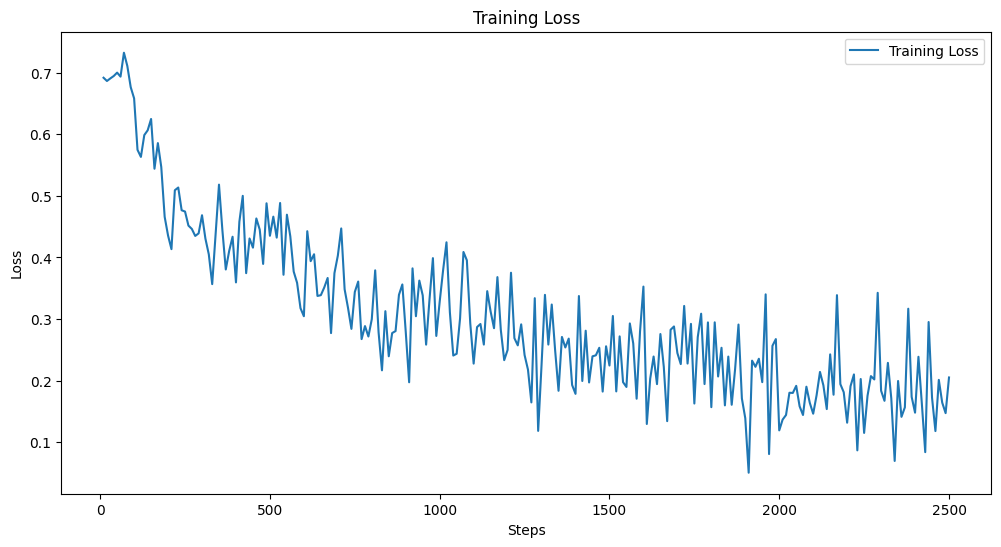

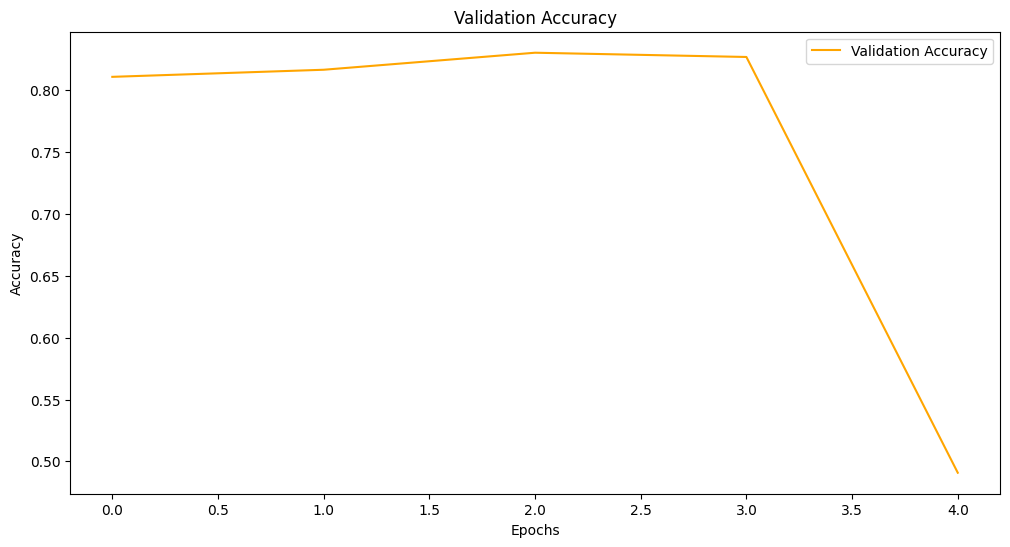

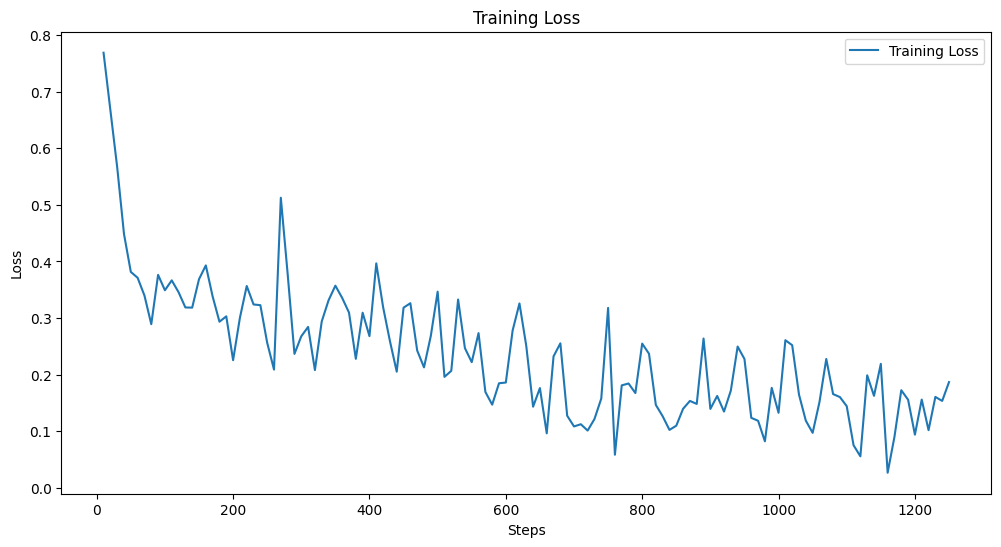

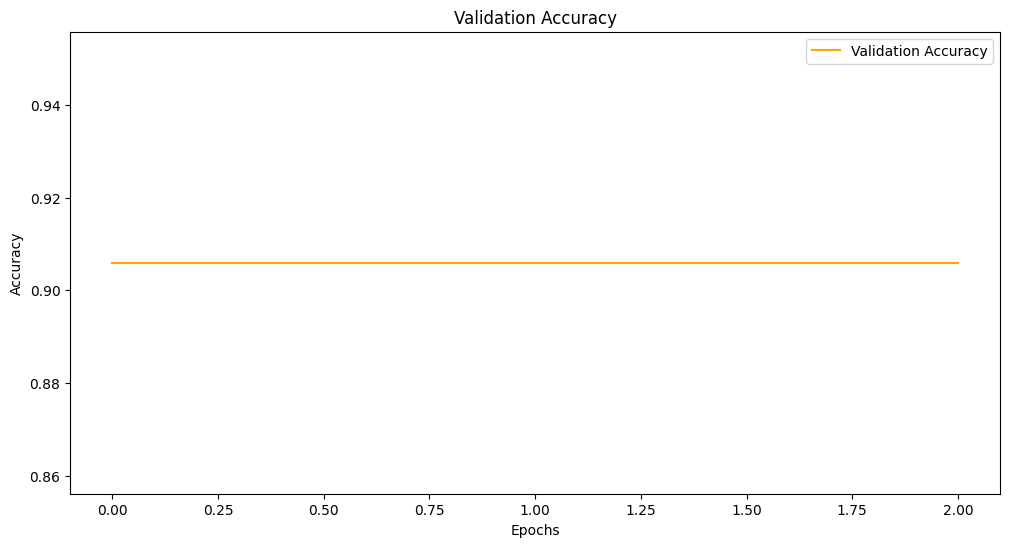

In [5]:
! mkdir outputs
! mkdir plots
! mkdir plots/adact
! mkdir plots/bert
# Save Results
save_results(trainer_adact.evaluate(), "./outputs/adact_results.json")
save_results(trainer.evaluate(), "./outputs/bert_results.json")

# Plot Metrics
plot_metrics(trainer_adact.state.log_history, "./plots/adact")
plot_metrics(trainer.state.log_history, "./plots/bert")

In [6]:
! zip -r outputs.zip outputs
! zip -r plots.zip plots

  adding: outputs/ (stored 0%)
  adding: outputs/bert_results.json (deflated 49%)
  adding: outputs/adact_results.json (deflated 47%)
  adding: plots/ (stored 0%)
  adding: plots/bert/ (stored 0%)
  adding: plots/bert/loss_plot.png (deflated 7%)
  adding: plots/bert/accuracy_plot.png (deflated 28%)
  adding: plots/adact/ (stored 0%)
  adding: plots/adact/loss_plot.png (deflated 6%)
  adding: plots/adact/accuracy_plot.png (deflated 18%)
